In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# ----------------------------
# STEP 1: Load and visualize data
# ----------------------------
df = pd.read_csv("UBER.csv")   # make sure this file is in the same directory
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
print(df.head())
print("\nColumns:", df.columns.tolist())


        Date       Open       High        Low      Close  Adj Close     Volume
0 2019-05-10  42.000000  45.000000  41.060001  41.570000  41.570000  186322500
1 2019-05-13  38.790001  39.240002  36.080002  37.099998  37.099998   79442400
2 2019-05-14  38.310001  39.959999  36.849998  39.959999  39.959999   46661100
3 2019-05-15  39.369999  41.880001  38.950001  41.290001  41.290001   36086100
4 2019-05-16  41.480000  44.060001  41.250000  43.000000  43.000000   38115500

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [6]:
# Use 'Close' column for prediction (like share_market notebook)
data = df[['Date', 'Close']].copy()
data.set_index('Date', inplace=True)

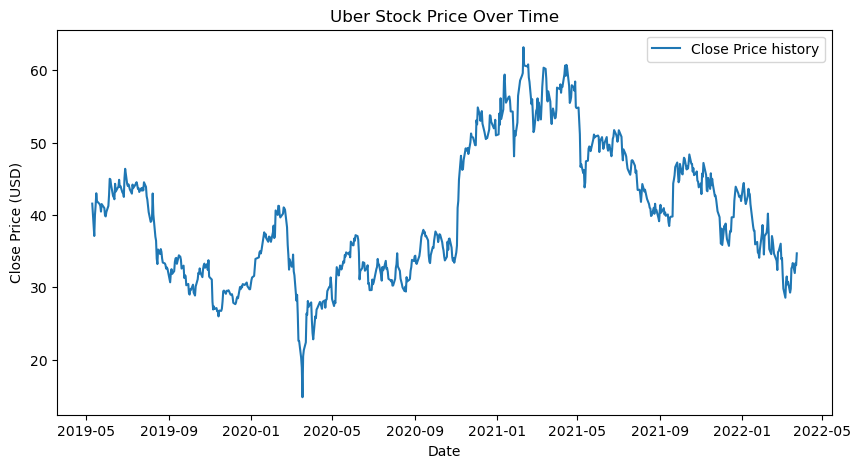

In [7]:
plt.figure(figsize=(10,5))
plt.plot(data['Close'], label='Close Price history')
plt.title("Uber Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

In [8]:
# ----------------------------
# STEP 2: Prepare data for LSTM
# ----------------------------
dataset = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(dataset) * 0.8))


In [9]:
# Create training dataset
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []
SEQ_LEN = 60  # number of past days to look back
for i in range(SEQ_LEN, len(train_data)):
    x_train.append(train_data[i-SEQ_LEN:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("Training samples:", x_train.shape[0])

Training samples: 520


In [10]:
# ----------------------------
# STEP 3: Build the LSTM model
# ----------------------------
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))  # output layer

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

c:\Users\Madeehah\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ----------------------------
# STEP 4: Train the model
# ----------------------------
validation_data = scaled_data[training_data_len - SEQ_LEN:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(SEQ_LEN, len(validation_data)):
    x_test.append(validation_data[i-SEQ_LEN:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

history = model.fit(x_train, y_train, validation_data=(x_test, scaler.transform(y_test)),
                    epochs=50, batch_size=32, verbose=1, callbacks=[es])


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0

In [14]:
# ----------------------------
# STEP 4.5: Save model and scaler
# ----------------------------

# Save the trained model in HDF5 format
model.save("uber_lstm_model.h5")
print("✅ Model saved as uber_lstm_model.h5")

# Save the MinMaxScaler using pickle
import joblib
joblib.dump(scaler, "uber_scaler.pkl")
print("✅ Scaler saved as uber_scaler.pkl")

✅ Model saved as uber_lstm_model.h5
✅ Scaler saved as uber_scaler.pkl


In [15]:
# ----------------------------
# STEP 5: Make predictions
# ----------------------------
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f"RMSE: {rmse:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
RMSE: 1.7520


In [16]:
# ----------------------------
# STEP 6: Visualize results
# ----------------------------
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\Madeehah\AppData\Local\Temp\ipykernel_4232\315644043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


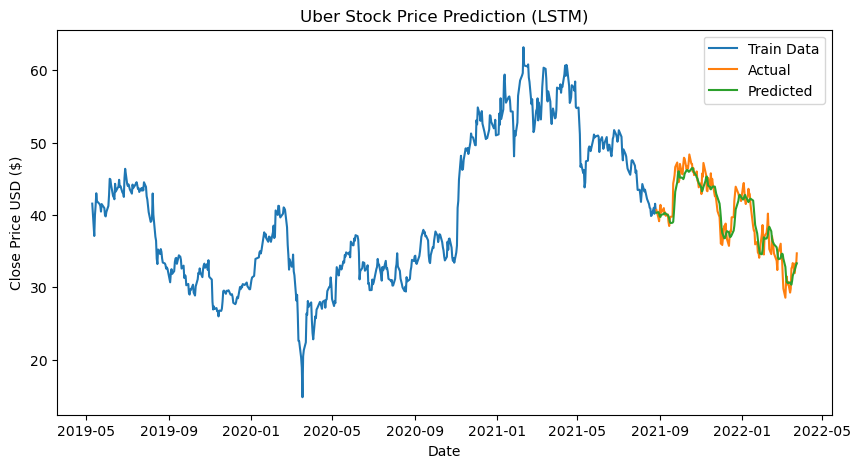

In [17]:
plt.figure(figsize=(10,5))
plt.title('Uber Stock Price Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'], label='Train Data')
plt.plot(valid[['Close', 'Predictions']], label=['Actual', 'Predicted'])
plt.legend()
plt.show()


In [18]:
# ----------------------------
# STEP 7: Predict future days
# ----------------------------
# Use last 60 days to predict the next N days
last_60_days = scaled_data[-SEQ_LEN:]
future_days = 10  # Change this to predict more days

future_input = last_60_days.copy()
future_predictions = []


In [19]:
for _ in range(future_days):
    X_future = np.reshape(future_input[-SEQ_LEN:], (1, SEQ_LEN, 1))
    pred = model.predict(X_future)
    future_predictions.append(pred[0][0])
    future_input = np.append(future_input, pred)[-SEQ_LEN:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [20]:
# Inverse transform future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [22]:
# Create future date range
future_dates = pd.date_range(start=data.index[-1], periods=future_days+1, inclusive='right')
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions.flatten()})
print("\nFuture Predicted Prices:\n", future_df)



Future Predicted Prices:
         Date  Predicted_Close
0 2022-03-25        33.768631
1 2022-03-26        34.002594
2 2022-03-27        34.134892
3 2022-03-28        34.212925
4 2022-03-29        34.258842
5 2022-03-30        34.284374
6 2022-03-31        34.296665
7 2022-04-01        34.300602
8 2022-04-02        34.299740
9 2022-04-03        34.296719


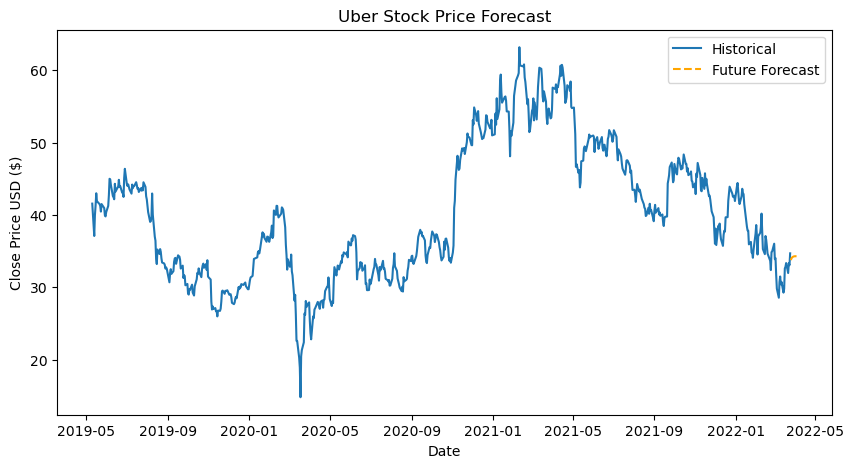

In [23]:
plt.figure(figsize=(10,5))
plt.plot(data['Close'], label='Historical')
plt.plot(future_df['Date'], future_df['Predicted_Close'], label='Future Forecast', linestyle='--', color='orange')
plt.title('Uber Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

In [24]:
# ----------------------------
# STEP 7.5: Save predictions
# ----------------------------
valid.to_csv("uber_predictions.csv", index=True)
future_df.to_csv("uber_future_forecast.csv", index=False)
print("✅ Predictions saved as uber_predictions.csv")
print("✅ Future forecast saved as uber_future_forecast.csv")


✅ Predictions saved as uber_predictions.csv
✅ Future forecast saved as uber_future_forecast.csv
